In [25]:
from pylanetary.pylanetary.planetnav.core import *
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

# Overview

This tutorial showcases the utilities contained in the planetnav subpackage of pylanetary. Learn how to use the ModelPlanetEllipsoid and PlanetNav classes

# make a projected model planet disk

Compute latitude, longitude, emission angle values for an ellipsoidal planetary body on a given pixel scale with given north polar angle and sub-observer latitude and longitude

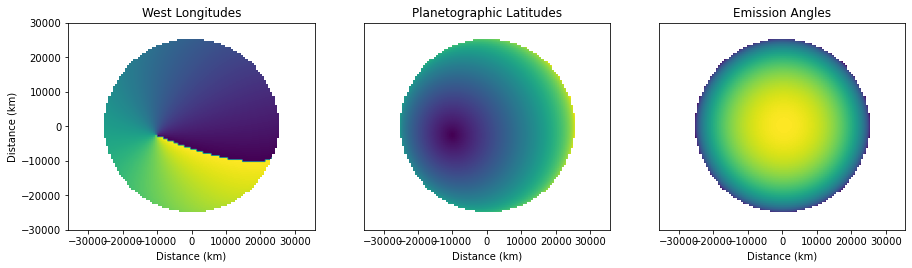

In [26]:
shape = (119,100)
ob_lon = 37.1 #degrees
ob_lat = -65 #degrees
pixscale_km = 600
np_ang = 285 #degrees
req = 25560 #km
rpol = 24970 #km

ellipsoid = ModelPlanetEllipsoid(shape, ob_lon, ob_lat, pixscale_km, np_ang, req, rpol)

extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(ellipsoid.lon_w, origin = 'lower', extent=extent)
ax0.set_title('West Longitudes')
im1 = ax1.imshow(ellipsoid.lat_g, origin = 'lower', extent=extent)
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(ellipsoid.mu, origin = 'lower', extent=extent)
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (km)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (km)')

plt.show()

# save these as np arrays for testing suite - delete later
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/lat_g.npy', ellipsoid.lat_g)
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/lon_w.npy', ellipsoid.lon_w)
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/surf_n.npy', ellipsoid.surf_n)
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/mu.npy', ellipsoid.mu)

# model corresponding to real data

## instantiate model from Horizons

In [27]:
from astropy.io import fits
from astroquery.jplhorizons import Horizons
from datetime import datetime, timedelta

hdul = fits.open('data/h_2019oct28.fits') #urh60.fits
pixscale_arcsec = 0.009942 #arcsec, keck

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]
start_time = datetime.strptime(obs_time, '%Y-%m-%d %H:%M:%S')
end_time = start_time + timedelta(minutes=1)
epochs = {'start':obs_time, 'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 'step':'1m'}

# convert pixscale from arcsec to km
obj = Horizons(id='799', location='568', epochs=epochs) #Uranus, Keck
ephem = obj.ephemerides()
d_AU = ephem['delta'][0]*u.au
dist = d_AU.to(u.km).value
pixscale_km = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))
print(f'pixel scale is {pixscale_km} km')

# image size also from header
imsize = header['NAXIS1']

nav = PlanetNav(data, ephem[0], req, rpol, pixscale_arcsec)

# save ephemeris as astropy Table for testing suite - delete later
from astropy import io
io.misc.hdf5.write_table_hdf5(ephem, '/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/ephem.hdf5', 
    serialize_meta=True,
    overwrite=True)
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/keck_uranus.npy', data)

pixel scale is 135.79676018335573 km


/Users/emolter/anaconda/envs/py39/lib/python3.9/site-packages/astropy/io/misc/hdf5.py:268: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  warnings.warn("table path was not set via the path= argument; "


## Make limb-darkened disk model, then center and shift

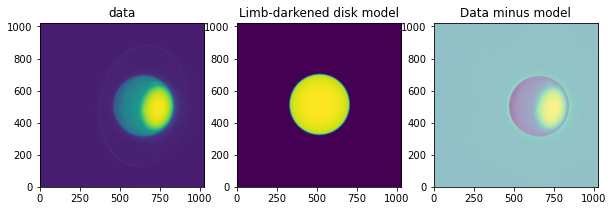

suggested x,y shift is 137.794921875 -10.744140625


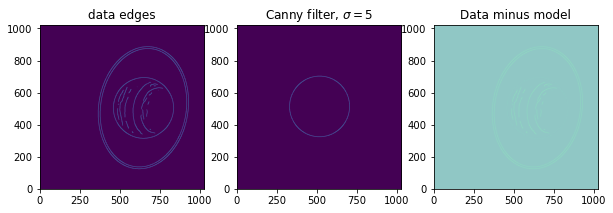

Canny x,y shift is 130.048828125 -9.201171875


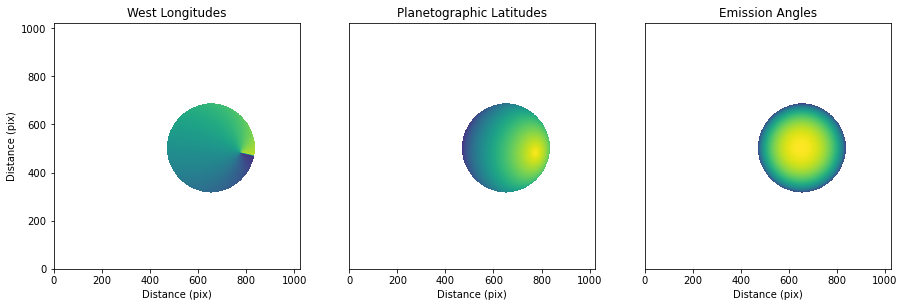

In [28]:
# try centering using convolution with limb-darkened disk
flux = 2000 # surface brightness in whatever units are in the fits file
a = 0.1 # exponential limb-darkening law exponent
fwhm_keck = 0.05 # approximate FWHM of the point-spread function in arcsec
ldmodel = nav.ldmodel(flux, a, beamsize = fwhm_keck, law='exp')

# save ldmodel as numpy file for testing suite - delete later
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/ldmodel.npy', ldmodel)

# center the lat, lon, and mu grids. 
# note it is not necessary to make the ldmodel explictly above in order to run centering
dx, dy, _, _ = nav.colocate(mode='disk', tb = flux, a = a, beamsize = fwhm_keck)
print('suggested x,y shift is', dx, dy)

# we could also use an edge-detection algorithm. this is useful if 
# the planet disk is faint and the clouds are bright, e.g., for Neptune in K-band
dx_canny, dy_canny, _, _ = nav.colocate(mode='canny', low_thresh=1e-5, high_thresh=0.01, sigma=5)
print('Canny x,y shift is', dx_canny, dy_canny)

nav.xy_shift_model(dx, dy)
## note: alternatively, we could center the data
# nav.xy_shift_data(-dx, -dy)


#extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(nav.lon_w, origin = 'lower')
ax0.set_title('West Longitudes')
im1 = ax1.imshow(nav.lat_g, origin = 'lower')
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(nav.mu, origin = 'lower')
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (pix)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (pix)')
    ax.set_aspect('equal')

plt.show()

# save one of these as np array for testing suite - delete later
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/lat_g_keck.npy', nav.lat_g)

## reproject data onto lat-lon grid

New image will be 1171 by 585 pixels
Pixel scale 135.796760 km = 3.247187 pixels per degree


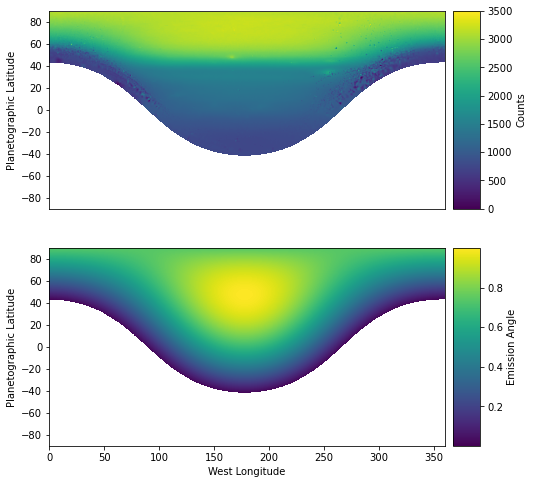

In [29]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
projected, mu_projected = nav.reproject()

extent = (0, 360, -90, 90)
fig, (ax0, ax1) = plt.subplots(2,1, figsize = (8,8))

im0 = ax0.imshow(projected, origin = 'lower', extent=extent, vmin=0, vmax = 3500)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(im0, cax=cax0, label='Counts')

im1 = ax1.imshow(mu_projected, origin = 'lower', extent=extent)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1, label='Emission Angle')

ax0.set_ylabel('Planetographic Latitude')
ax1.set_ylabel('Planetographic Latitude')
ax1.set_xlabel('West Longitude')
ax0.set_xticks([])

plt.show()

# save these as np array for testing suite - delete later
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/projected.npy', projected)
np.save('/Users/emolter/Python/pylanetary/pylanetary/planetnav/tests/data/mu_projected.npy', mu_projected)

This works well! For planets with banded structure, it is easy to check the quality of the co-location based on whether or not the bands appear straight in these images. If the centroid is shifted, then the bands are curved! 

Note here that by default, reproject() will keep the same pixel scale as the original data at the sub-observer point. This means that at every other location, the projected image is oversampled as compared with the original data. This oversampling of the original pixel grid can cause unusual-looking artifacts near the limbs of the planet. To change this default behavior, simply use: reproject(pixscale_arcsec=float)

## save outputs as fits

Internal save functions are not yet implemented